In [1]:
import seaborn as sns
import pandas as pd

summ = pd.read_csv('summary_table_v1.4.csv')
raw = pd.read_csv('drugcomb_data_v1.4.csv')

block_to_study = raw[['block_id', 'study_name']].drop_duplicates()
summ = summ.merge(block_to_study, on='block_id')

mono = summ[summ['drug_col'].isna()]
comb = summ[~summ['drug_col'].isna()]

k562_mono = mono[mono['cell_line_name'] == 'K-562']
k562_combs = comb[comb['cell_line_name'] == 'K-562']

/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
from sklearn import preprocessing
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

def get_normalized_df(in_df, norm_fxn, score_names):
    res_df = in_df.copy()
    for score_name in score_names:
        vals = get_normalized_vals(in_df, norm_fxn, score_name)
        res_df['%s_norm' % score_name] = vals
        
    return res_df

def get_normalized_vals(df, norm_fxn, score_name):
    vals = [norm_fxn(group[score_name]) for _, group in df.groupby('cell_line_name')]
    return np.concatenate(vals)

def plt_norm(scores):
    norm = plt.Normalize(vmin=scores.min(), vmax=scores.max())
    return norm(scores)

def l2_norm(scores):
    # Make data have unit l2 norm
    vals = scores.values.reshape(1, -1)
    return preprocessing.normalize(vals, norm='l2').squeeze()

def l1_norm(scores):
    # Make data have unit l1 norm
    vals = scores.values.reshape(1, -1)
    return preprocessing.normalize(vals, norm='l1').squeeze()

def unit_gaussian(scores):
    # Make data abide by unit gaussian
    vals = scores.values.reshape(-1, 1)
    return preprocessing.scale(vals)

def plot_scores(df, x_score, y_score, use_norm=False):
    x_score = '%s_norm' % x_score if use_norm else x_score
    y_score = '%s_norm' % y_score if use_norm else y_score
    
    g = sns.FacetGrid(data=df, col='cell_line_name', col_wrap=5)
    g.map(sns.scatterplot, x_score, y_score)
    g.add_legend()

    g.savefig('%s_%s_all_lines.png' % (x_score, y_score))
    
def get_r2_df(df, use_norm=False):
    res = pd.DataFrame(columns=['cell_line_name', 'r2_score', 'type'])    
    norm_str = '_norm' if use_norm else ''
    x_score = 'synergy_zip%s' % norm_str
    y_score = 'synergy_loewe%s' % norm_str
    
    for score_comb in [[x_score, y_score], [y_score, x_score]]:
        rows = []
        r2_name = ('%s_to_%s_r2' % tuple(score_comb)).replace('_norm', '')
        for name, group in df.groupby('cell_line_name'):
            score = r2_score(group[score_comb[1]], group[score_comb[0]])
            rows.append({
                'cell_line_name': name, 
                'r2_score': score, 
                'type': r2_name
            })
            
        res = res.append(pd.DataFrame(rows))
            
    return res

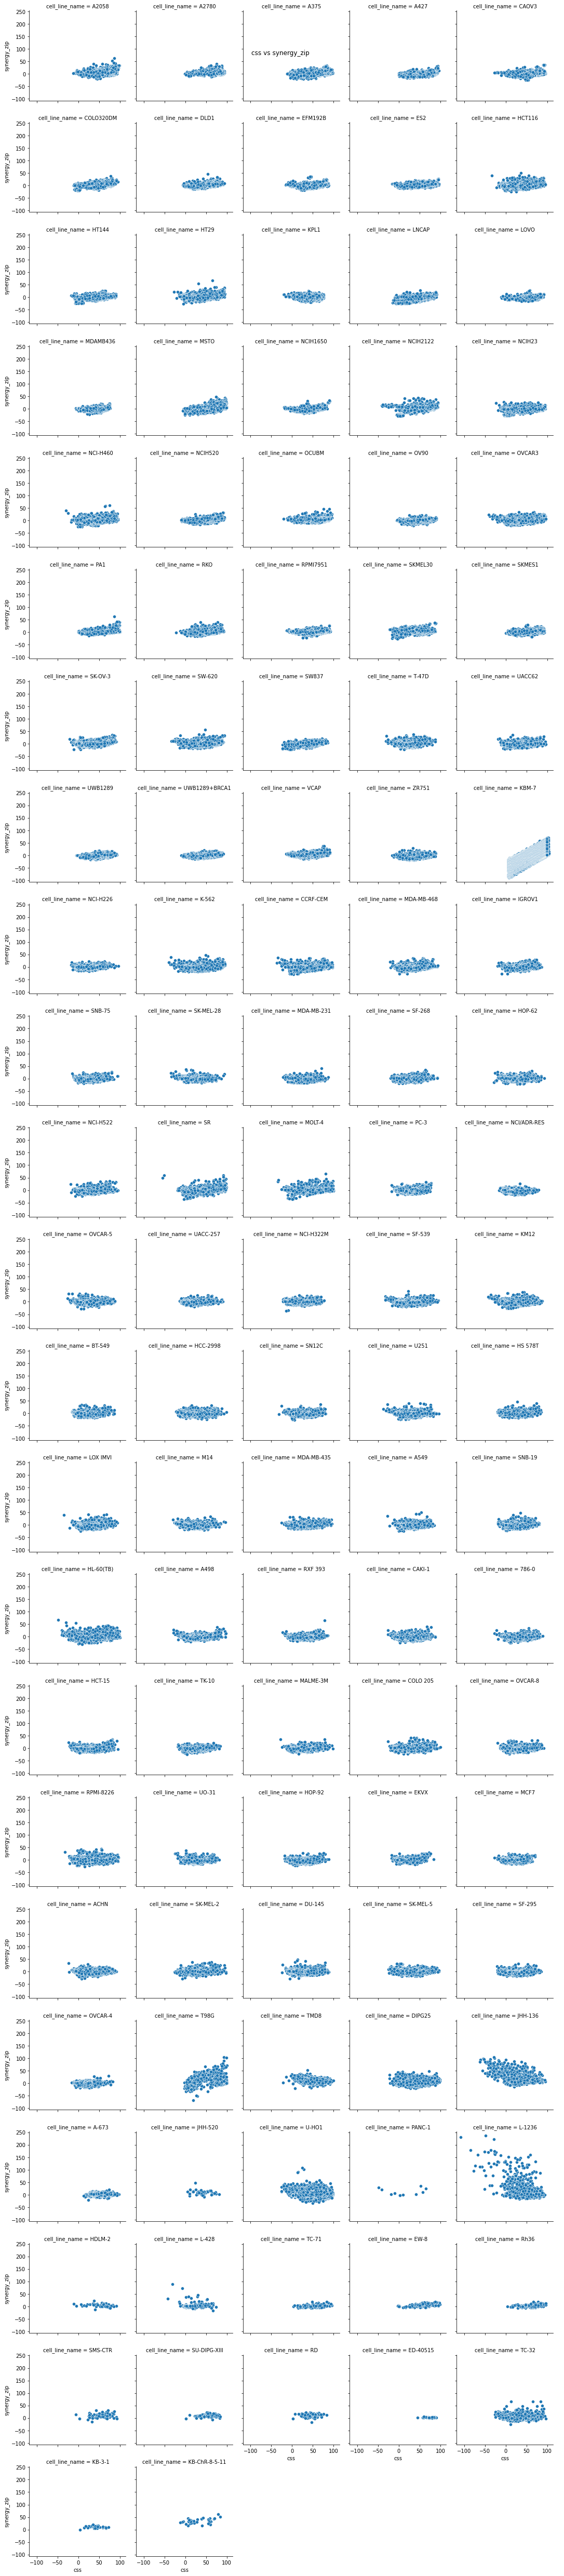

In [97]:
plot_scores(comb, 'css', 'synergy_zip')

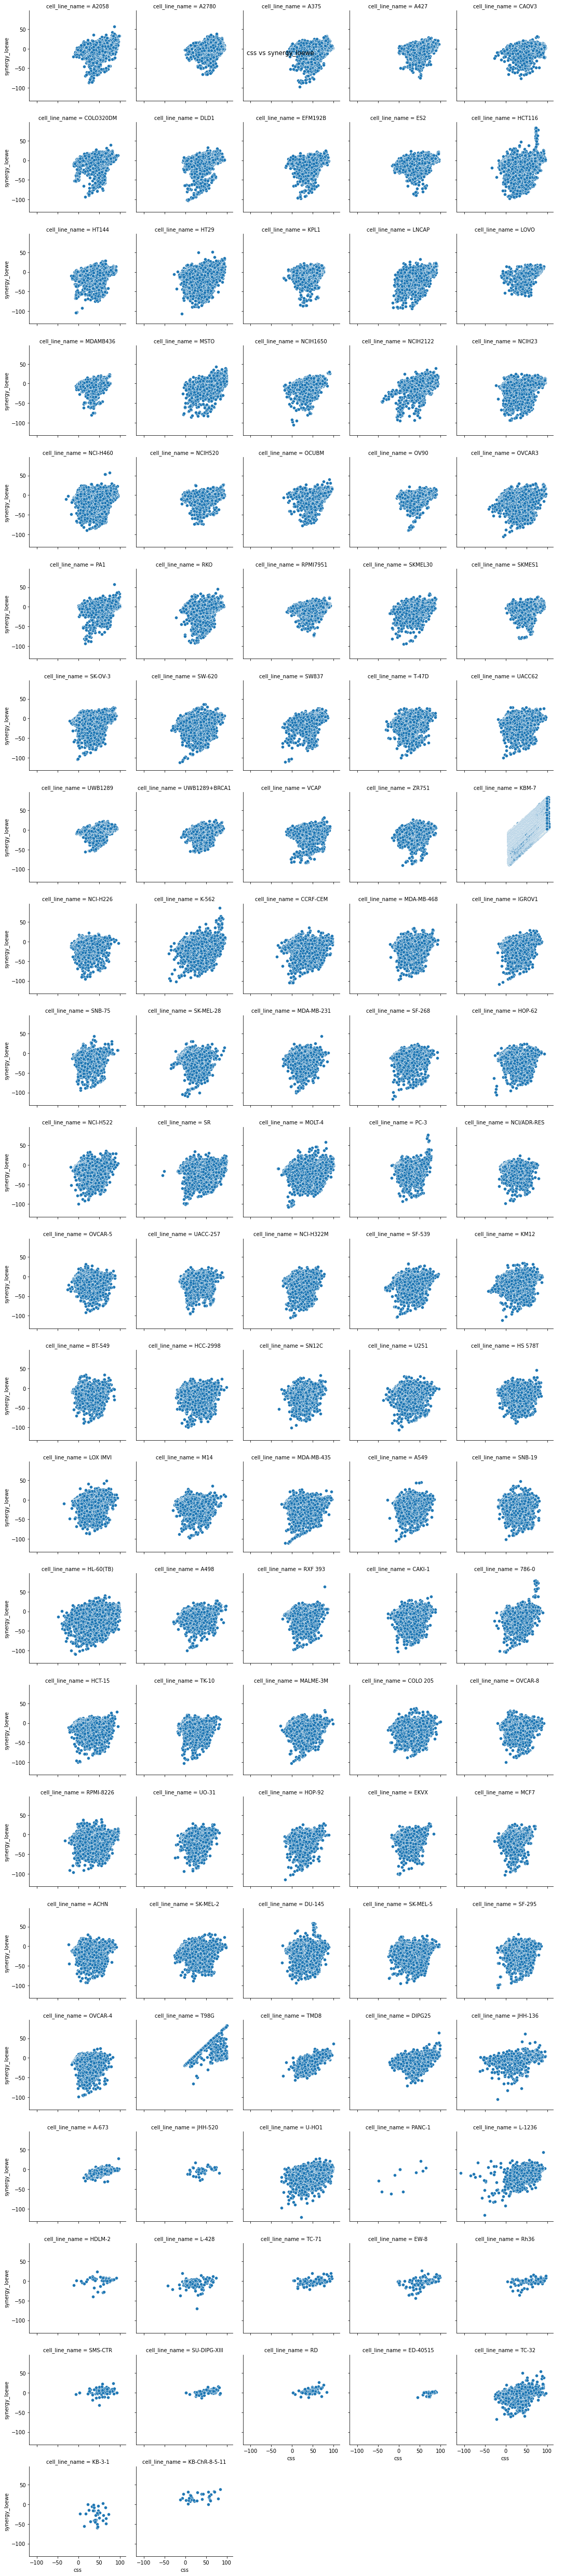

In [98]:
plot_scores('css', 'synergy_loewe')

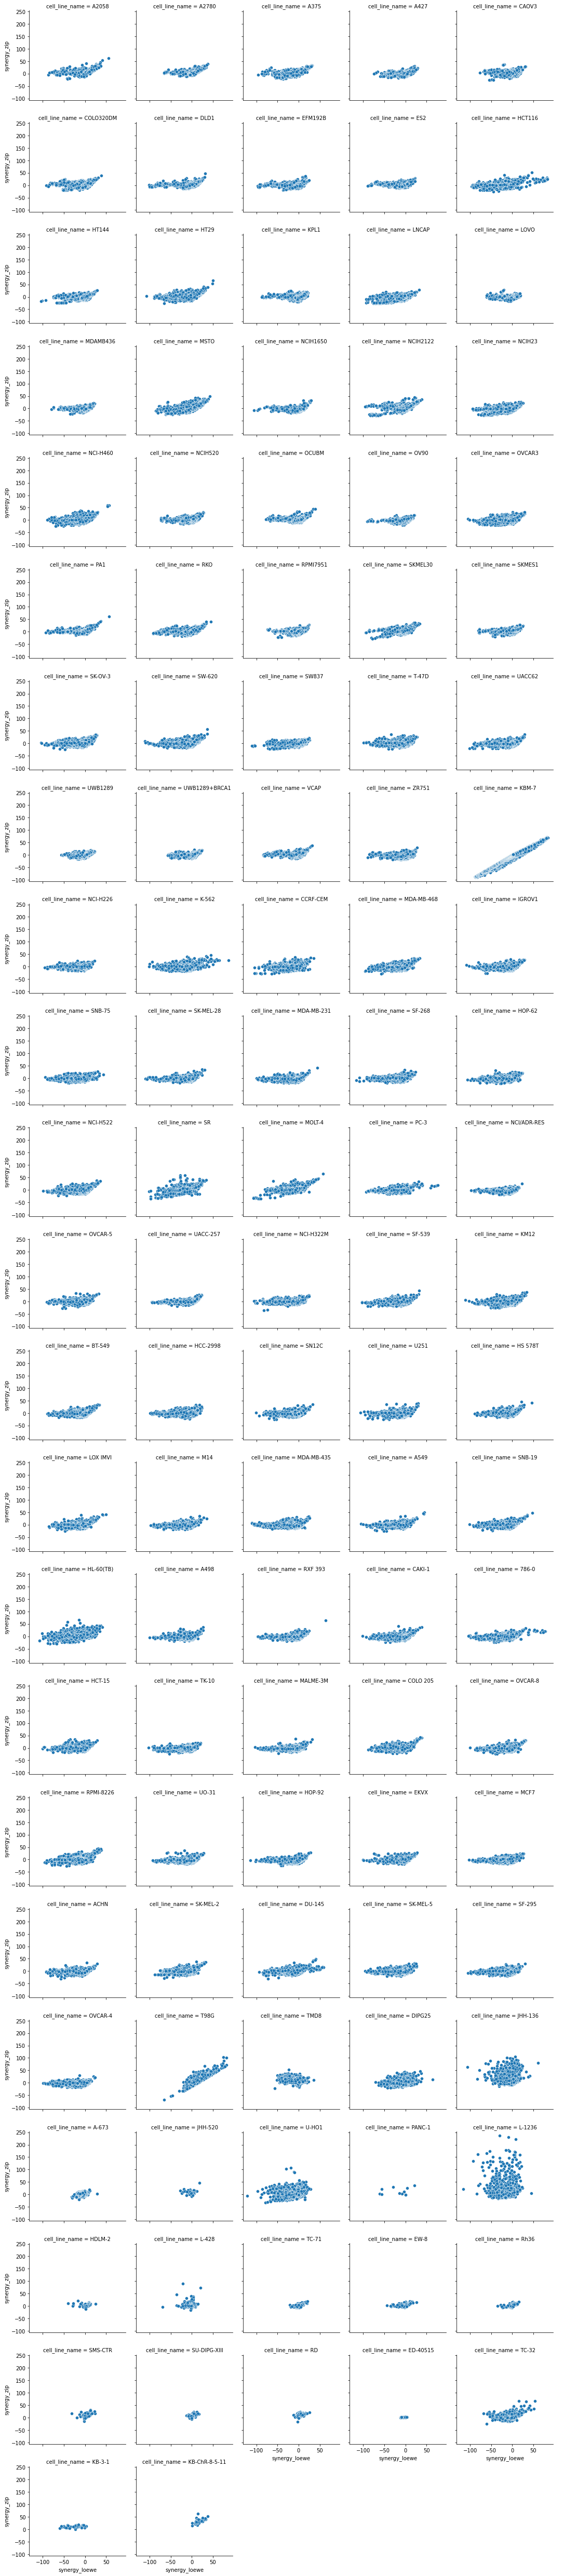

In [4]:
plot_scores('synergy_loewe', 'synergy_zip')

In [5]:
plt_norm_df = get_normalized_df(comb, plt_norm, ['synergy_zip', 'synergy_loewe'])
l1_norm_df = get_normalized_df(comb, l1_norm, ['synergy_zip', 'synergy_loewe'])
l2_norm_df = get_normalized_df(comb, l2_norm, ['synergy_zip', 'synergy_loewe'])
unit_gaussian_df = get_normalized_df(comb, unit_gaussian, ['synergy_zip', 'synergy_loewe'])

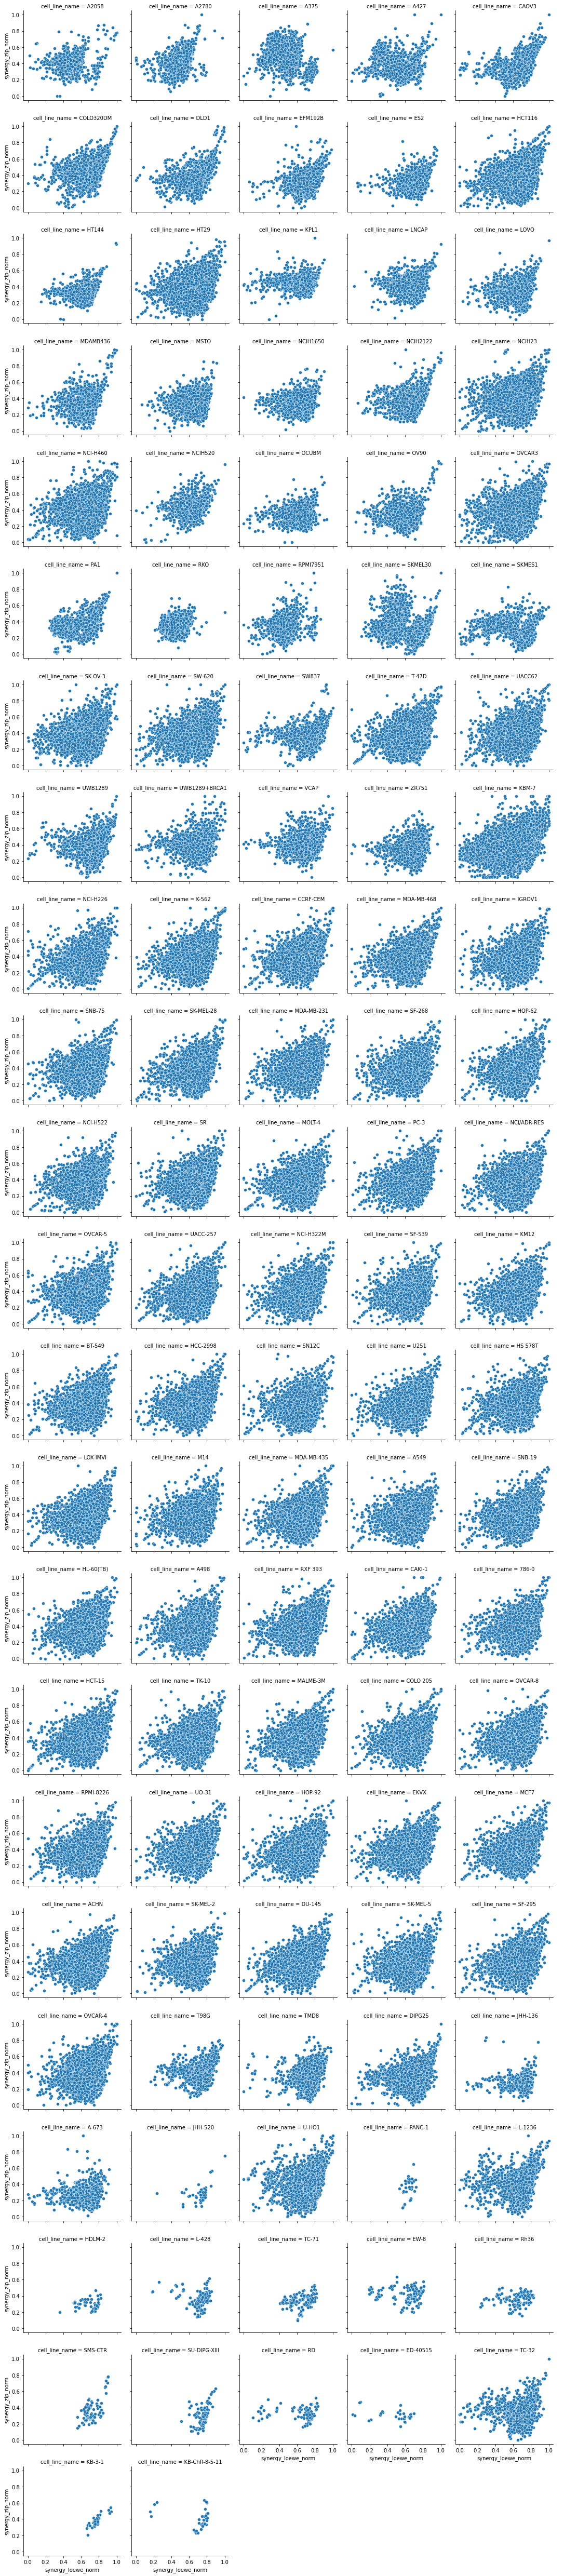

In [6]:
plot_scores(plt_norm_df, 'synergy_loewe', 'synergy_zip', use_norm=True)

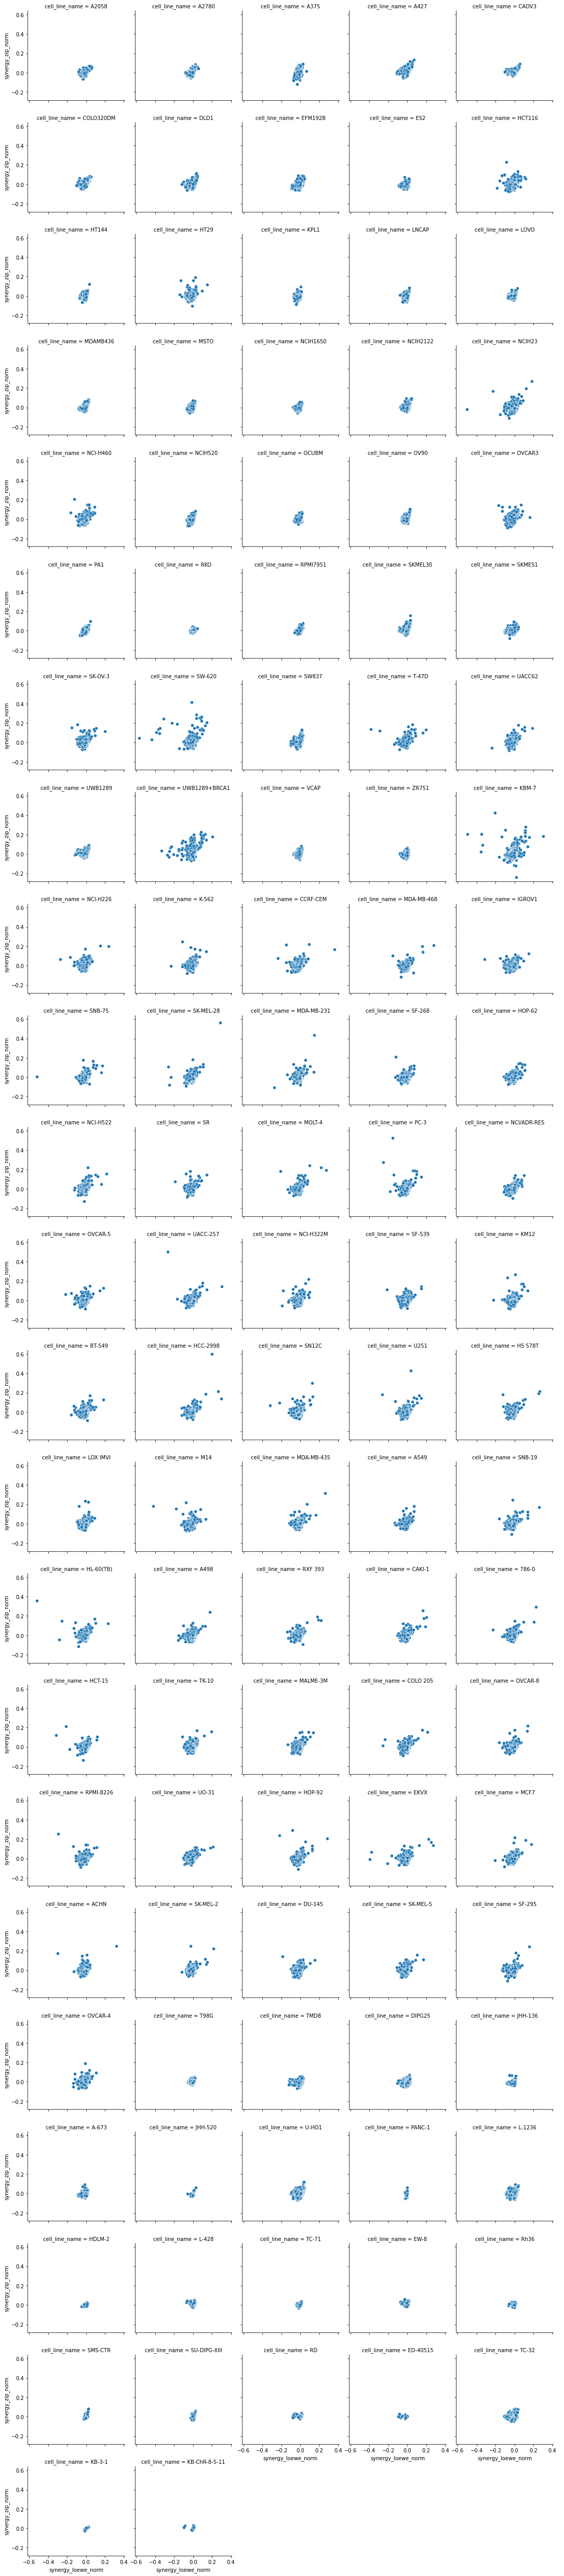

In [7]:
plot_scores(l2_norm_df, 'synergy_loewe', 'synergy_zip', use_norm=True)

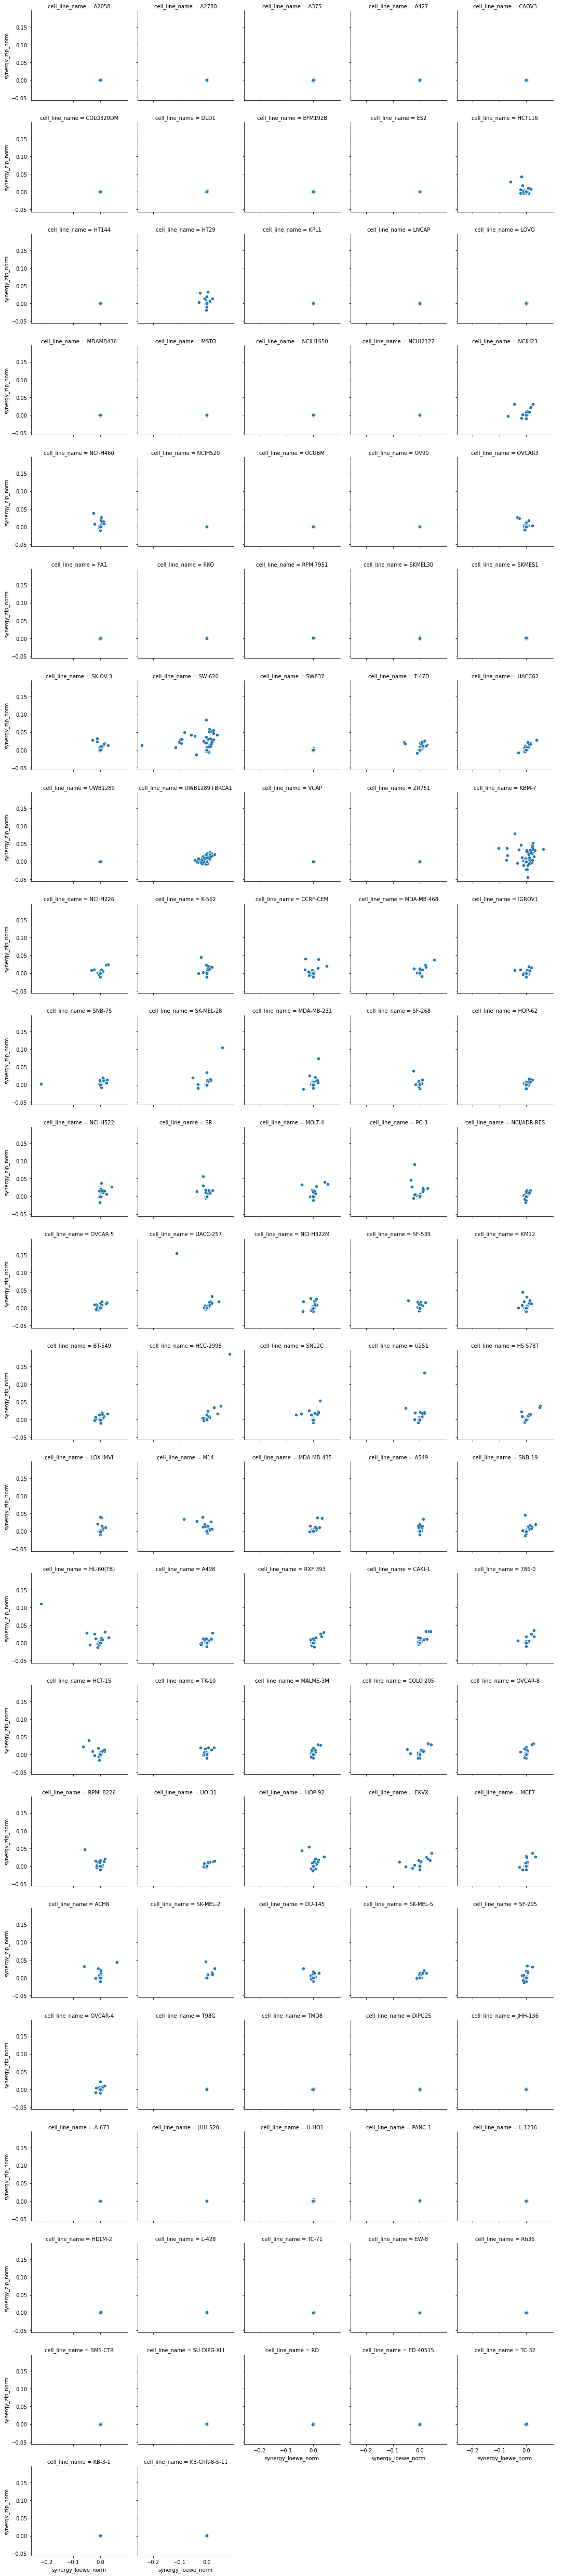

In [8]:
plot_scores(l1_norm_df, 'synergy_loewe', 'synergy_zip', use_norm=True)

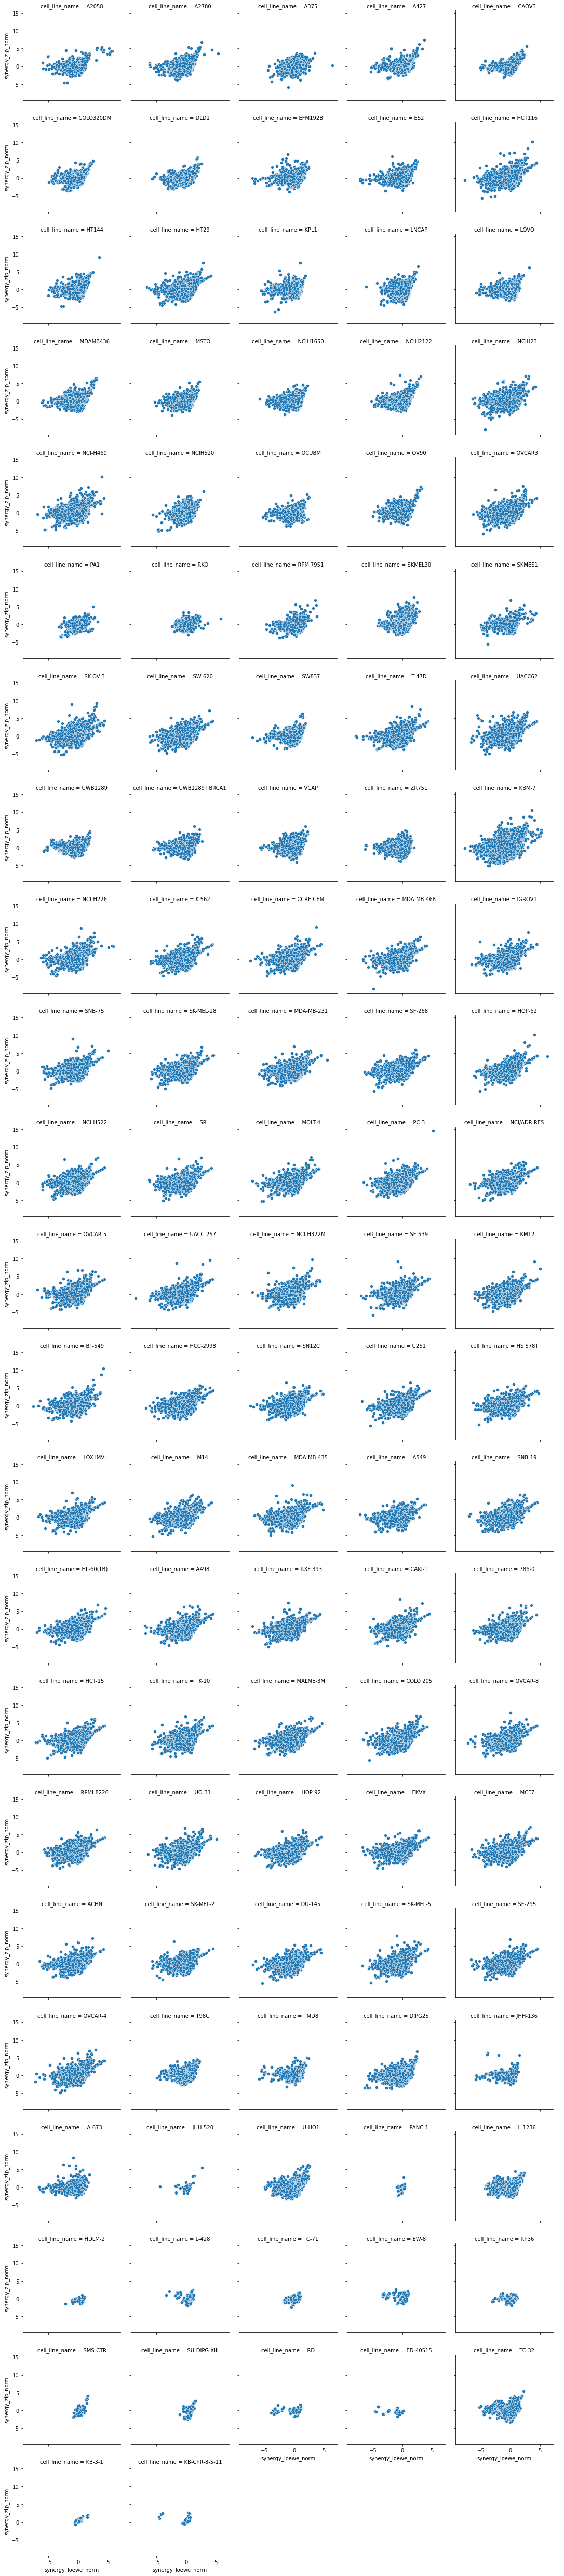

In [9]:
plot_scores(unit_gaussian_df, 'synergy_loewe', 'synergy_zip', use_norm=True)

In [10]:
comb_r2 = get_r2_df(comb)

In [11]:
comb_r2

cell_line_name   r2_score                             type
0            786-0  -0.196553  synergy_zip_to_synergy_loewe_r2
1            A-673  -3.117637  synergy_zip_to_synergy_loewe_r2
2            A2058  -0.160844  synergy_zip_to_synergy_loewe_r2
3            A2780   0.041307  synergy_zip_to_synergy_loewe_r2
4             A375  -0.205738  synergy_zip_to_synergy_loewe_r2
..             ...        ...                              ...
107          UO-31  -7.544689  synergy_loewe_to_synergy_zip_r2
108        UWB1289  -3.359684  synergy_loewe_to_synergy_zip_r2
109  UWB1289+BRCA1  -6.207720  synergy_loewe_to_synergy_zip_r2
110           VCAP -10.842908  synergy_loewe_to_synergy_zip_r2
111          ZR751  -5.269348  synergy_loewe_to_synergy_zip_r2

[224 rows x 3 columns]

In [12]:
gaussian_r2 = get_r2_df(unit_gaussian_df, use_norm=True)

In [13]:
sns.histplot(data=gaussian_r2, x='synergy_zip_to_synergy_loewe_r2')

ValueError: Could not interpret value `synergy_zip_to_synergy_loewe_r2` for parameter `x`

In [14]:
def plot_r2_dist(df):
    with sns.plotting_context(font_scale=1):
        g = sns.FacetGrid(df, col='type', height=6, aspect = 1)
        sns.set(font_scale=1)
        g.map(sns.histplot, 'r2_score')

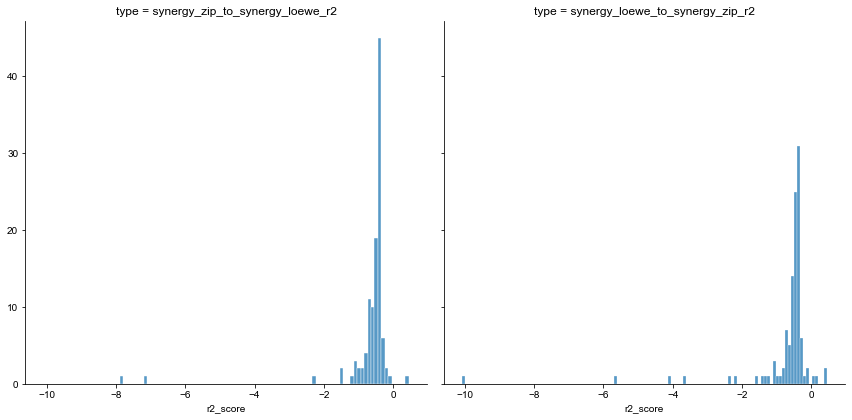

In [15]:
plot_r2_dist(gaussian_r2)

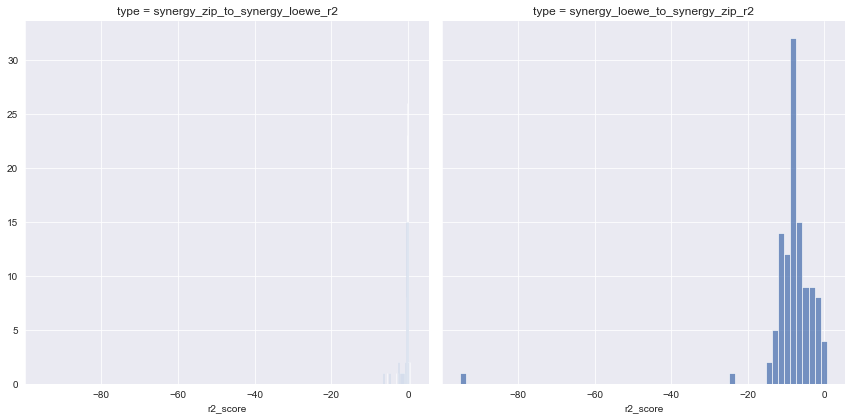

In [16]:
plot_r2_dist(comb_r2)

In [3]:
alm_raw = raw[raw['study_name'] == 'ALMANAC']

In [4]:
alm_concs = pd.concat((alm_raw['conc_r'], alm_raw['conc_c']))

In [5]:
alm_concs = alm_concs.reset_index().rename(columns={0: 'conc'}).drop(columns=['index'])

In [20]:
alm_concs.groupby('log_conc').size()

KeyError: 'log_conc'

In [ ]:
alm_concs['log_conc'] = np.log(alm_concs['conc'])

In [ ]:
alm_concs['log_conc']

In [ ]:
alm_raw[['conc_r', 'conc_c']]

In [ ]:
raw.columns

In [21]:
concs = pd.concat((raw['conc_r'], raw['conc_c']))

In [22]:
sns.histplot(alm_concs)

Error in callback <function flush_figures at 0x7fc20895d5f0> (for post_execute):


KeyboardInterrupt: 

In [23]:
alm_raw['drug_row'].unique()

array(['CYTARABINE HYDROCHLORIDE', 'MERCAPTOPURINE', 'MITOMYCINE',
       'CHEMBL17639', 'TEMOZOLOMIDE', "5-FLUORO-2'-DEOXYURIDINE",
       'ZOLINZA', 'BUSULFAN', 'LAPATINIB',
       'MECHLORETHAMINE HYDROCHLORIDE', 'VINBLASTINE SULFATE',
       'IFOSFAMIDE', 'IMIQUIMOD', 'AMINOLEVULINIC ACID HYDROCHLORIDE',
       'SN-38', 'SORAFENIB', 'AZACYTIDINE', 'ROMIDEPSIN', 'TRETINOIN',
       'DAUNORUBICIN HYDROCHLORIDE', 'FULVESTRANT', 'RALOXIFENE',
       '34793-34-5', 'PEMETREXED', 'TOPOTECAN HYDROCHLORIDE',
       'METHOTREXATE', 'CELECOXIB', 'ACTINOMYCIN D', 'NSC733504',
       'PACLITAXEL', 'NILOTINIB', 'TAMOXIFEN CITRATE', 'LOMUSTINE',
       'IMATINIB', 'ANTIBIOTIC AD 32', 'CYCLOPHOSPHAMIDE',
       'FLUDARABINE BASE', 'CHEMBL277800', 'CARBOPLATIN',
       'VINCRISTINE SULFATE', 'SUNITINIB', 'PRALATREXATE',
       'GEMZAR (LILLY)', 'BLEOMYCIN', 'DOCETAXEL', 'DEXRAZOXANE',
       'NSC141540', 'HYDROXYUREA', 'QUINACRINE HYDROCHLORIDE',
       'MELPHALAN HYDROCHLORIDE', 'MITOTANE',
      

In [24]:
alm_raw[alm_raw['drug_row'] == 'BORTEZOMIB']

block_id  conc_r  conc_c  inhibition    drug_row           drug_col  \
2493312    134086   0.000   0.000   -0.000626  BORTEZOMIB   ARSENIC TRIOXIDE   
2493313    134086   0.000   0.060   -0.049670  BORTEZOMIB   ARSENIC TRIOXIDE   
2493314    134086   0.000   0.600    7.170576  BORTEZOMIB   ARSENIC TRIOXIDE   
2493315    134086   0.000   6.000   77.989379  BORTEZOMIB   ARSENIC TRIOXIDE   
2493316    134086   0.003   0.000   13.470184  BORTEZOMIB   ARSENIC TRIOXIDE   
...           ...     ...     ...         ...         ...                ...   
7535707    443643   0.100   0.001   60.025890  BORTEZOMIB  ADM HYDROCHLORIDE   
7535708    443643   0.100   0.010   60.679750  BORTEZOMIB  ADM HYDROCHLORIDE   
7535709    443643   0.100   0.100   63.543120  BORTEZOMIB  ADM HYDROCHLORIDE   
7535710    443643   0.100   1.000   94.473740  BORTEZOMIB  ADM HYDROCHLORIDE   
7535711    443643   0.100  10.000   78.680330  BORTEZOMIB  ADM HYDROCHLORIDE   

        conc_r_unit conc_c_unit cell_line_name  drug_row_cid  drug_col_cid  \
2493312          uM          uM          SN12C        387447         14888   
2493313          uM          uM          SN12C        387447         14888   
2493314          uM          uM          SN12C        387447         14888   
2493315          uM          uM          SN12C        387447         14888   
2493316          uM          uM          SN12C        387447         14888   
...             ...         ...            ...           ...           ...   
7535707          uM          uM           A549        387447         32874   
7535708          uM          uM           A549        387447         32874   
7535709          uM          uM           A549        387447         32874   
7535710          uM          uM           A549        387447         32874   
7535711          uM          uM           A549        387447         32874   

        cellosaurus_accession study_name  
2493312             CVCL_1705    ALMANAC  
2493313             CVCL_1705    ALMANAC  
2493314             CVCL_1705    ALMANAC  
2493315             CVCL_1705    ALMANAC  
2493316             CVCL_1705    ALMANAC  
...                       ...        ...  
7535707             CVCL_0023    ALMANAC  
7535708             CVCL_0023    ALMANAC  
7535709             CVCL_0023    ALMANAC  
7535710             CVCL_0023    ALMANAC  
7535711             CVCL_0023    ALMANAC  

[4392 rows x 13 columns]

In [25]:
alm_raw.groupby('drug_row')['conc_r'].unique()

drug_row
1-(5-DEOXYPENTOFURANOSYL)-5-FLUORO-4-{[(PENTYLOXY)CARBONYL]AMINO}PYRIMIDIN-2(1H)-ONE                [0.0, 0.2, 2.0, 20.0, 0.1, 1.0, 10.0]
34793-34-5                                                                                        [0.0, 0.2, 2.0, 20.0, 1.0, 10.0, 100.0]
5-FLUORO-2'-DEOXYURIDINE                                                                [0.0, 0.0007, 0.006999999999999999, 0.07, 0.01...
5-FU                                                                                                              [0.0, 1.0, 10.0, 100.0]
ABIRATERONE                                                                                                         [0.0, 0.05, 0.5, 5.0]
                                                                                                              ...                        
VINBLASTINE SULFATE                                                                       [0.0, 0.0003, 0.003, 0.03, 0.0001, 0.001, 0.01]
VINCRISTINE SULFATE      

In [26]:
gb = alm_raw.groupby('block_id')

In [ ]:
gb['conc_r'].unique().shape

In [ ]:
gb.size()

In [ ]:
sns.histplot(gb.size())

In [ ]:
alm_data = pd.read_csv('~/Downloads/ComboDrugGrowth_Nov2017.csv')

In [ ]:
alm_data.columns

In [ ]:
pd.concat((alm_data['NSC1'], alm_data['NSC2'])).unique().shape

In [ ]:
sns.histplot(alm_data.groupby(['NSC1', 'NSC2', 'CELLNAME']).size())

In [ ]:
alm_data['CONC1'].unique()

In [ ]:
alm_raw[alm_raw['block_id'] == 132369]

In [ ]:
v = pd.concat((alm_raw['drug_col'], alm_raw['drug_row'])).unique()

In [ ]:
import numpy as np

x = np.array(list(filter(lambda y: y[:3] == 'NSC', v)))

In [ ]:
x

In [ ]:
exp_w_nsc_names = alm_raw[(alm_raw['drug_col'].isin(x)) & (alm_raw['drug_row'].isin(x))]

In [ ]:
exp_w_nsc_names.groupby(['drug_row', 'drug_col']).size()

In [ ]:
sns.histplot(exp_w_nsc_names.groupby('block_id').size())

In [ ]:
import re

dig_re = re.compile(r'\d+')

for col_name in ['drug_row', 'drug_col']:
    exp_w_nsc_names[col_name] = exp_w_nsc_names[col_name].apply(lambda x: dig_re.findall(x)[0])

In [ ]:
exp_w_nsc_names

In [ ]:
alm_data = alm_data.rename(columns={'CELLNAME': 'cell_line_name'})

In [ ]:
merged = exp_w_nsc_names.merge(alm_data, on=['drug_row', 'drug_col', 'cell_line_name'])

In [ ]:
for col_name in ['drug_row', 'drug_col']:
    exp_w_nsc_names[col_name] = pd.to_numeric(exp_w_nsc_names[col_name])

In [ ]:
dup = exp_w_nsc_names.copy()
tmp = dup['drug_row'].copy()
dup['drug_row'] = dup['drug_col'].copy()
dup['drug_col'] = tmp

In [ ]:
merged['block_id'].unique()

In [ ]:
exp_w_nsc_names = exp_w_nsc_names.append(dup)

In [ ]:
v = merged[merged['block_id'] == 292204]

In [ ]:
for col_name in ['conc_r', 'conc_c', 'CONC1', 'CONC2']:
    print('For column %s have the values %r' % (col_name, v[col_name].unique()))

In [ ]:
v['CONCUNIT1']

In [ ]:
alm_raw[alm_raw['block_id'] == 132661]

In [6]:
alm_summ = summ[summ['study_name'] == 'ALMANAC']

In [ ]:
sns.histplot(alm_summ[alm_summ['synergy_zip'] > 20]['synergy_zip'])

In [ ]:
sns.histplot(alm_summ['synergy_zip'])

In [ ]:
alm_summ['synergy_zip'].min()

In [40]:
import math

num_bins = 70

def get_bins(df, num_bins, synergy_col):
    zip_synergies = df[synergy_col]
    min_val = math.floor(zip_synergies.min())
    max_val = math.ceil(zip_synergies.max())

    diff = max_val - min_val
    
    base_num_per_bucket, remainder = divmod(diff, num_bins)
    idxs_with_extra = np.random.choice(np.arange(num_bins), remainder, replace=False)
    
    tpls = []
    curr = min_val
    for i in range(num_bins):
        bucket_range = base_num_per_bucket
        if np.isin(i, idxs_with_extra).item():
            bucket_range += 1
            
        tpls.append((curr, curr + bucket_range))
        curr = curr + bucket_range
        
    interv_idx = pd.IntervalIndex.from_tuples(tpls)
    return pd.cut(df[synergy_col], interv_idx, include_lowest=True)
        

In [ ]:
diff / num_bins

In [ ]:
quo, rem = divmod(diff, num_bins)

In [ ]:
idxs_to_incr = np.random.choice(np.arange(num_bins), rem, replace=False)

In [ ]:
idxs_to_incr

In [ ]:
np.isin(0, idxs_to_incr).item()

In [8]:
alm_summ['bins'] = get_bins(alm_summ, 20)

TypeError: get_bins() missing 1 required positional argument: 'synergy_col'

In [ ]:
alm_summ.groupby('bins').size()

In [11]:
other = alm_summ.copy()

In [12]:
other['drug_other'] = other['drug_col']

In [13]:
def swap_cols(df, first_col_name, second_col_name):
    tmp = df[first_col_name].copy()
    df[first_col_name] = df[second_col_name]
    df[second_col_name] = tmp


In [ ]:
other

In [14]:
swap_drug_cols(other)

NameError: name 'swap_drug_cols' is not defined

In [ ]:
alm_summ.merge(other, on='drug_row')

In [9]:
def merge(df1, df2, merge_on='drug_col'):
    cols = ['drug_row', 'drug_col', 'cell_line_name']

    merged = df1.merge(df2, how='inner', on=[merge_on, 'cell_line_name'])
    
    col_to_fix = 'drug_row' if merge_on == 'drug_col' else 'drug_col'
    cols = {merge_on: 'drug1', '%s_x' % col_to_fix: 'drug2', '%s_y' % col_to_fix: 'drug3'}
    return merged.rename(columns=cols)

In [15]:
merged = merge(alm_summ, other)

In [17]:
merged

block_id_x                     drug2      drug1 cell_line_name  \
0             132369  CYTARABINE HYDROCHLORIDE  NSC733504       NCI-H226   
1             132369  CYTARABINE HYDROCHLORIDE  NSC733504       NCI-H226   
2             132369  CYTARABINE HYDROCHLORIDE  NSC733504       NCI-H226   
3             132369  CYTARABINE HYDROCHLORIDE  NSC733504       NCI-H226   
4             132369  CYTARABINE HYDROCHLORIDE  NSC733504       NCI-H226   
...              ...                       ...        ...            ...   
20670463      443547                AMIFOSTINE  NSC256439        OVCAR-8   
20670464      443547                AMIFOSTINE  NSC256439        OVCAR-8   
20670465      443547                AMIFOSTINE  NSC256439        OVCAR-8   
20670466      443547                AMIFOSTINE  NSC256439        OVCAR-8   
20670467      443547                AMIFOSTINE  NSC256439        OVCAR-8   

         conc_r_unit_x conc_c_unit_x    css_x  synergy_zip_x  synergy_bliss_x  \
0                   uM            uM   1.8875      -0.672451          1.10124   
1                   uM            uM   1.8875      -0.672451          1.10124   
2                   uM            uM   1.8875      -0.672451          1.10124   
3                   uM            uM   1.8875      -0.672451          1.10124   
4                   uM            uM   1.8875      -0.672451          1.10124   
...                ...           ...      ...            ...              ...   
20670463            uM            uM  35.6225      -0.322393         -2.25837   
20670464            uM            uM  35.6225      -0.322393         -2.25837   
20670465            uM            uM  35.6225      -0.322393         -2.25837   
20670466            uM            uM  35.6225      -0.322393         -2.25837   
20670467            uM            uM  35.6225      -0.322393         -2.25837   

          synergy_loewe_x  ...  synergy_hsa_y  ic50_row_y  ic50_col_y  \
0               -0.256734  ...       0.066454    0.098297    0.047535   
1               -0.256734  ...       0.506168    0.486536    0.047535   
2               -0.256734  ...      -4.846665    5.000000    0.047535   
3               -0.256734  ...       1.231980    0.010000    0.047535   
4               -0.256734  ...      -1.725554    5.000000    0.047535   
...                   ...  ...            ...         ...         ...   
20670463       -24.365043  ...      -8.713872    0.001416    0.098013   
20670464       -24.365043  ...      -4.353098    0.026720    0.098013   
20670465       -24.365043  ...       0.630860    1.159360    0.098013   
20670466       -24.365043  ...       5.826159    0.024028    0.098013   
20670467       -24.365043  ...      -1.357284  100.000000    0.098013   

          ri_row_y  ri_col_y  css_row_y  css_col_y      S_y study_name_y  \
0            0.368     0.009      2.620      1.155   1.5105      ALMANAC   
1           -2.162     0.009      1.976      6.003   6.1425      ALMANAC   
2           -2.210     0.009     -5.502     -1.580  -1.3400      ALMANAC   
3            2.510     0.009      1.872     10.496   3.6650      ALMANAC   
4           -3.977     0.009      1.759     -0.309   4.6930      ALMANAC   
...            ...       ...        ...        ...      ...          ...   
20670463    55.548    24.877     52.517     29.738 -39.2975      ALMANAC   
20670464    25.876    24.877     43.439     39.953  -9.0570      ALMANAC   
20670465    18.125    24.877     47.229     34.893  -1.9410      ALMANAC   
20670466     8.878    24.877     48.434     40.102  10.5130      ALMANAC   
20670467     1.107    24.877     46.731     24.514   9.6385      ALMANAC   

          drug_other  
0          NSC733504  
1          NSC733504  
2          NSC733504  
3          NSC733504  
4          NSC733504  
...              ...  
20670463   NSC256439  
20670464   NSC256439  
20670465   NSC256439  
20670466   NSC256439  
20670467   NSC256439  

[20670468 rows x 37 columns]

In [ ]:
alm_summ.shape

In [16]:
v = merged[['drug_row_x', 'drug_col', 'drug_row_y']].drop_duplicates()

KeyError: "None of [Index(['drug_row_x', 'drug_col', 'drug_row_y'], dtype='object')] are in the [columns]"

In [18]:
v_c = v.copy()
swap_cols(v_c, 'drug_row_x', 'drug_row_y')

NameError: name 'v' is not defined

In [ ]:
v.append(v_c).drop_duplicates()

In [ ]:
v.drop_duplicates()

In [ ]:
195848 * 2

In [ ]:
v['names'] = v.apply(lambda x: '|'.join(sorted(x)), axis=1)

In [ ]:
v['names'].drop_duplicates()

In [ ]:
v_n = merge(alm_summ, other, merge_on='drug_row')[['drug_col_x', 'drug_col_y', 'drug_row']]

In [ ]:
v_n['names'] = v_n.apply(lambda x: '|'.join(sorted(x)), axis=1).drop_duplicates()

In [ ]:
pd.concat((v['names'], v_n['names'])).drop_duplicates()

In [19]:
def get_triplet_df(df):
    copy = df.copy()
    swap_cols(copy, 'drug_row', 'drug_col')
    
    merged_dfs = [merge(df, copy, merge_on=col_name) for col_name in ['drug_row']]#, 'drug_col']]
    all_df = merged_dfs[0]
    if len(merged_dfs) == 2:
        all_df = all_df.append(merged_dfs[1])
    
    all_df['comb_name'] = all_df[['drug1', 'drug2', 'drug3']].apply(lambda x: '|'.join(sorted(x)), axis=1)
    all_df['comb_name'] = all_df[['comb_name', 'cell_line_name']].apply(lambda x: '|'.join(x), axis=1)
    
    all_df = all_df.drop_duplicates(subset='comb_name')
    return all_df

In [20]:
triplet_df = get_triplet_df(alm_summ)

In [21]:
other_triplet_df = get_triplet_df(alm_summ)

KeyboardInterrupt: 

In [ ]:
print(other_triplet_df.shape[0])
print(triplet_df.shape[0])

In [22]:
k562_triplets = triplet_df[triplet_df['cell_line_name'] == 'K-562']

In [23]:
k562_triplets['expected_zip'] = (k562_triplets['synergy_zip_x'] + k562_triplets['synergy_zip_y']) / 2

/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
sns.histplot(k562_triplets['expected_zip'])

In [ ]:
k562_triplets['expected_zip'].min()

In [24]:
def plot_both_above_thresh(thresh):
    sns.histplot(k562_triplets[(k562_triplets['synergy_zip_x'] > thresh) & (k562_triplets['synergy_zip_y'] > thresh)]['expected_zip'])

In [ ]:
plot_both_above_thresh(15)

In [25]:
k562_triplets['bins'] = get_bins(k562_triplets, 30, 'expected_zip')
k562_triplets.groupby('bins').size()

/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


bins
(-17, -15]       12
(-15, -13]      102
(-13, -11]      528
(-11, -10]      717
(-10, -8]      3435
(-8, -6]       7731
(-6, -5]       6757
(-5, -3]      19962
(-3, -1]      29495
(-1, 1]       32116
(1, 3]        24577
(3, 5]        14932
(5, 7]         8740
(7, 9]         5031
(9, 10]        1745
(10, 12]       2680
(12, 14]       1641
(14, 16]        972
(16, 18]        568
(18, 20]        268
(20, 22]        177
(22, 23]         50
(23, 25]         69
(25, 27]         46
(27, 29]         17
(29, 31]         16
(31, 33]          4
(33, 35]          5
(35, 37]          2
(37, 39]          1
dtype: int64

In [26]:
intervals = sorted(k562_triplets['bins'].unique(), reverse=True)
k562_triplets[k562_triplets['bins'] == intervals[0]][['synergy_zip_x', 'synergy_zip_y']]

synergy_zip_x  synergy_zip_y
9137496      29.581147      46.651338

In [27]:
import matplotlib.pyplot as plt

def plot(num_bins):
    for interval in intervals[:num_bins]:
        match = k562_triplets[k562_triplets['bins'] == interval]
        synergies = pd.concat((match['synergy_zip_x'], match['synergy_zip_y']))
        
        plt.figure()
        sns.histplot(synergies)
        plt.title('For bin %r' % interval)

In [28]:
def _get_selections_inner(df, num_selections):
    '''
    The procedure calls for us to take an even number of samples from
    each bucket.  However, this may not be possible, specifically in the
    case that some bucket does not have the requisite number of items in it.
    
    In this case, we will resample the remaining required samples from the 
    buckets leftover.  This method does one iteration of the bucket sampling,
    and will be called as many times as needed for when buckets do not have
    enough items in them.
    '''
    result_samples = []
    num_leftover = 0
    
    bins = list(sorted(df['bins'].unique(), reverse=True))
    
    base_items_per_bucket, remainder = divmod(num_selections, len(bins))
    idxs_with_extra = np.random.choice(np.arange(len(bins)), remainder, replace=False)
    
    for i, bin_ in enumerate(bins):
        num_samples_this_bin = base_items_per_bucket
        if np.isin(i, idxs_with_extra).item():
            num_samples_this_bin += 1
            
        matches = df[df['bins'] == bin_]
        
        sample = None
        if matches.shape[0] < num_samples_this_bin:
            sample = matches
            num_leftover += num_samples_this_bin - matches.shape[0]
        else:
            sample = matches.sample(n=num_samples_this_bin)
            
        result_samples.append(sample)
        
    return pd.concat(result_samples), num_leftover

def get_selections(df, num_selections):
    # Copy df so we can make deletions
    copy_df = df.copy()
    selections = pd.DataFrame(columns=copy_df.columns)
    
    while num_selections:
        samples, num_leftover = _get_selections_inner(copy_df, num_selections)
        
        # Delete rows from copy_df that we just selected
        copy_df = pd.concat((copy_df, samples)).drop_duplicates(keep=False)
        num_selections = num_leftover
        selections = selections.append(samples)
        
    return selections
        

In [29]:
selections = get_selections(k562_triplets, 500)
selections['comb_name']

9137496            ACTINOMYCIN D|LAPATINIB|VEMURAFENIB|K-562
3429786          DOCETAXEL|LAPATINIB|TAMOXIFEN CITRATE|K-562
9137438            ACTINOMYCIN D|TRETINOIN|VEMURAFENIB|K-562
3429733           DOCETAXEL|MITOTANE|TAMOXIFEN CITRATE|K-562
3430634          DOCETAXEL|SORAFENIB|TAMOXIFEN CITRATE|K-562
                                 ...                        
9730090                     5-FU|AMIFOSTINE|MITOMYCINE|K-562
9172382                 5-FU|MERCAPTOPURINE|VISMODEGIB|K-562
9655185    LOMUSTINE|NSC256439|TOPOTECAN HYDROCHLORIDE|K-562
9896683            CISPLATINO|LOMUSTINE|URACIL MUSTARD|K-562
108983                      5-FU|AZACYTIDINE|NSC256439|K-562
Name: comb_name, Length: 500, dtype: object

In [ ]:
selections

In [31]:
sheet = pd.read_excel('~/Downloads/k562_drugs_and_in_apexbiolib_status_ams.xlsx')

In [32]:
possible_in_apexbio = sheet[(~sheet['UsedInChemoGenomics-at-IRIC'].isna()) | sheet['Is in ApexBio']]

In [33]:
apexbio_names = possible_in_apexbio['Name'].drop_duplicates()

In [34]:
apexbio_k562_cond = k562_triplets['drug1'].isin(apexbio_names) & k562_triplets['drug2'].isin(apexbio_names) & k562_triplets['drug3'].isin(apexbio_names)

In [35]:
apexbio_k562_triplets = k562_triplets[apexbio_k562_cond]

In [ ]:
sns.histplot(apexbio_k562_triplets['expected_zip'])

In [ ]:
sns.histplot(get_selections(apexbio_k562_triplets, 500)['expected_zip'])

In [36]:
apexbio_selections = get_selections(apexbio_k562_triplets, 500)

In [ ]:
apexbio_selections.columns

In [ ]:
raw.columns

In [37]:
def add_cid(df):
    ret_df = df.copy()
    
    tpls = []
    for v in ['row', 'col']:
        drug_name = 'drug_%s' % v
        cid_name  = 'drug_%s_cid' % v
        
        intermed_df = raw[[drug_name, cid_name]]
        intermed_df = intermed_df.rename(columns={drug_name: 'drug', cid_name: 'cid'})
        tpls.append(intermed_df)
        
    drug_cid_df = pd.concat(tpls)
    drug_cid_df = drug_cid_df.drop_duplicates()
    
    for idx in ['1', '2', '3']:
        to_drug_name = 'drug%s' % idx
        to_cid_name = 'drug%s_cid' % idx
        
        drug_cid_df = drug_cid_df.rename(columns={'drug': to_drug_name, 'cid': to_cid_name})
        ret_df = ret_df.merge(drug_cid_df, on=to_drug_name)
        drug_cid_df = drug_cid_df.rename(columns={to_drug_name: 'drug', to_cid_name: 'cid'})
        
    return ret_df

In [38]:
apexbio_selections_cid = add_cid(apexbio_selections)

In [39]:
apexbio_selections['drug3'].unique().shape

(60,)

In [ ]:
apexbio_selections_cid_uniq = apexbio_selections_cid.drop_duplicates(subset='comb_name')

In [ ]:
apexbio_selections_cid_uniq['drug3_cid'].isna().sum()

In [ ]:
sns.histplot(apexbio_selections_cid_uniq['expected_zip'])

In [ ]:
def get_dosing_info(drug_name):
    col_raw_match = raw[raw['drug_col'] == drug_name]
    row_raw_match = raw[raw['drug_row'] == drug_name]
    
    all_concs = pd.concat((col_raw_match['conc_c'], row_raw_match['conc_r']))
    return all_concs.drop_duplicates()
    

In [ ]:
selected_drugs = pd.concat((apexbio_selections_cid_uniq['drug%s' % idx] for idx in ['1', '2', '3']))
uniq_seld_drugs = selected_drugs.drop_duplicates()

In [ ]:
sns.histplot(uniq_seld_drugs.apply(lambda x: get_dosing_info(x).shape[0]))

In [ ]:
dosing_shapes = uniq_seld_drugs.apply(lambda x: get_dosing_info(x).shape[0])

In [ ]:
sns.histplot(dosing_shapes)

In [ ]:
dosing_shapes.unique().shape

In [ ]:
# drug1 and drug3 are drug_row, drug2 is drug_col
#def add_dosing_lists(df):
first_pair = raw[(raw['drug_row'] == apexbio_selections_cid_uniq['drug1']) & (raw['drug_col'] == apexbio_selections_cid_uniq['drug2'])]
second_pair = raw[(raw['drug_row'] == apexbio_selections_cid_uniq['drug3']) & (raw['drug_col'] == apexbio_selections_cid_uniq['drug2'])]

In [ ]:
from tqdm import tqdm, tqdm_pandas
import itertools

k562_raw = raw[raw['cell_line_name'] == 'K-562']
def match(v):
    cols = ['drug1', 'drug2', 'drug3']
    
    res_concs = {drug_col_name: pd.Series() for drug_col_name in cols}
    for perm in itertools.permutations(cols, r=2):
        row_name, col_name = perm[0], perm[1]
        experiments = k562_raw[(k562_raw['drug_row'] == v[row_name]) & (k562_raw['drug_col'] == v[col_name])]
        
        res_concs[row_name] = pd.concat((res_concs[row_name], experiments['conc_r']))
        res_concs[col_name] = pd.concat((res_concs[col_name], experiments['conc_c']))

    
    for drug_name, concs in res_concs.items():
        res_concs[drug_name] = concs.drop_duplicates()
    
    return res_concs['drug1'], res_concs['drug2'], res_concs['drug3']

def match_all_dataset(v):
    cols = ['drug1', 'drug2', 'drug3']
    res_concs = {drug_col_name: pd.Series() for drug_col_name in cols}
    
    for col in cols:
        first_experiments = k562_raw[k562_raw['drug_row'] == v[col]]
        scnd_experiments  = k562_raw[k562_raw['drug_col'] == v[col]]
        
        res_concs[col] = pd.concat((first_experiments['conc_r'], scnd_experiments['conc_c']))
        
    for drug_name, concs in res_concs.items():
        res_concs[drug_name] = concs.drop_duplicates()
    
    return res_concs['drug1'], res_concs['drug2'], res_concs['drug3']

In [ ]:
tqdm_pandas(tqdm())
matches = apexbio_selections_cid_uniq[['drug1', 'drug2', 'drug3']].progress_apply(lambda x: match(x), axis=1)

In [ ]:
matches_all = apexbio_selections_cid_uniq[['drug1', 'drug2', 'drug3']].progress_apply(lambda x: match_all_dataset(x), axis=1)

In [ ]:
def get_doses_naive(series, idx):
    return pd.Series([item[idx].tolist() for item in series])

def plot_for_matches(srs):
    for idx in range(3):
        plt.figure()
        sns.histplot(get_doses_naive(srs, idx).apply(lambda x: x.shape[0]))
        plt.title('Histogram for Drug %d' % (idx + 1))
        plt.xlabel('Number of Unique Dose Concentrations for Drug')

In [ ]:
plot_for_matches(matches)

In [ ]:
plot_for_matches(matches_all)

In [ ]:
d1_cs = get_doses_naive(matches, 0)
idx = d1_cs.apply(lambda x: x.shape[0]) == 6
d1_cs[idx][163]


In [ ]:
drug2_concs.filter(lambda x: x.shape[0] < 4)

In [ ]:
for i in range(3):
    drug_concs_new = get_doses_naive(matches, i)
    idx = drug_concs_new.apply(lambda x: x.shape[0]) < 4
    print(drug_concs_new[idx].shape)

In [ ]:
drug2_concs_new.apply(lambda x: x.shape[0]).filter(lambda y: y == 9)

In [ ]:
pd.concat((k562_raw['conc_c_unit'], k562_raw['conc_r_unit'])).unique()

In [ ]:
def is_10x_multiple(x, y):
    return np.isclose(x, y * 10)

def is_val_base(x, y):
    if np.isclose(x, y):
        return True
    
    v = x / y
    while v > 1:
        v /= 10
    
    return v.is_integer()

def constr_new_dosing(v):
    result = []
    for item in v:
        item = item[item != 0.0]
        
        bases = [z for z in item if not any(is_multiple(z, x) and z != x for x in item)]
        multiple_sets = [pd.Series([z for z in item if is_val_base(z, base)]) for base in bases]
        medians = pd.Series(srs.median() for srs in multiple_sets)
        
        # Take the median of the different multiple sets
        median = medians.median()
        
        result.append(pd.Series([0., median / 10, median, median * 10]))
    
    return result[0], result[1], result[2]
        

In [ ]:
new_dosings = matches.progress_apply(lambda x: constr_new_dosing(x))

In [ ]:
new_dosings

In [ ]:
apexbio_selections_cid_uniq = apexbio_selections_cid_uniq.drop(columns=['drug1_dosing'])
apexbio_selections_cid_uniq = apexbio_selections_cid_uniq.reset_index()

In [ ]:
for i in range(3):
    apexbio_selections_cid_uniq['drug%d_dosings' % (i + 1)] = get_doses_naive(new_dosings, i).tolist()
    apexbio_selections_cid_uniq['drug%d_dosings_unit' % (i + 1)] = 'uM'

In [ ]:
apexbio_selections_cid_uniq['comb_name'].unique()

In [ ]:
cols_for_new_df = ['drug1', 'drug2', 'drug3', 
                   'drug1_cid', 'drug2_cid', 'drug3_cid',
                   'drug1_dosings', 'drug2_dosings', 
                   'drug3_dosings', 'drug1_dosings_unit', 
                   'drug2_dosings_unit', 'drug3_dosings_unit', 
                   'cell_line_name', 'expected_zip']

selections_and_dosings = apexbio_selections_cid_uniq[cols_for_new_df]

In [ ]:
selections_and_dosings

In [ ]:
selections_and_dosings.to_csv('triplet_selections_and_dosings.csv')

In [ ]:
v = selections_and_dosings[['drug%d_cid' % (i + 1) for i in range(3)]].apply(lambda x: '|'.join(map(lambda y: str(y), sorted(x))), axis=1)

In [ ]:
v

In [ ]:
sns.histplot(selections_and_dosings['expected_zip'])

In [ ]:
summ

In [ ]:
summ[~summ['drug_col'].isna()]